Author: Gurjeet Singh (gurjeet.singh@helsinki.fi)

# MCMC for Poisson-Gamma

## Theoretical questions

**(a)** Write down the logarithm of the joint log probability.

$$ log p(\textbf{x}, u, v) = \prod_{i} log\left( p(x_i \vert x,v)\; p(u)\; p(v)\right) = log(p(u)) + log(p(v)) + \sum_{i}log p(x_i \vert x,v)$$


**(b)** Derive a Gibbs sampler for this model by providing the conditional distributions.

Posterior for $u$: 
$$ p(u \vert v,x) \propto p(x \vert u, v) p(u)$$
$$ log p(u)  = \alpha_0 log(\beta_0) - log \Gamma(\alpha_0) + (\alpha_0 - 1) log(u) - \beta_0 u $$
$$ log p(x_i \vert u,v)  = -uv + x_i log(u) + x_i log(v) - log(x_i \,!) $$

$$ p(u \vert v,x) \sim Gamma(\alpha_0 + \sum_{i}x_i,\; \beta_0 + n \; v) \quad where \;\; \alpha_0 = 5, \beta_0 = 1$$

Posterior for $v$: 

$$ p(v \vert v,x) \propto p(x \vert u, v) p(v) $$
$$ log p(u)  = \alpha_1 log(\beta_1) - log \Gamma(\alpha_1) + (\alpha_1 - 1) log(v) - \beta_1 v $$
$$ log p(x_i \vert u,v)  = -uv + x_i log(u) + x_i log(v) - log(x_i \,!) $$

$$ p(v \vert u,x) \sim Gamma(\alpha_1 + \sum_{i}x_i,\; \beta_1 + n\; u) \quad where \;\; \alpha_1 = 4,\; \beta_1 = 4$$

## Metropolis-Hasting sampler

Implement Metropolis-Hasting sampler for this model.

The probability distribution taken in consideration as proposal in the Metropolis-Hasting algorithm is a normal, lately the random samples from the distribution are transformed to positive number using the exponential function in order to avoid negative proposal for the two gamma distribution.

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import random
import os

from numpy.random import poisson
from numpy.random import gamma
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = [10, 10]

# Plotting the results of any sampler
def plotSamples(samples, warmup=500, type='-'):
    plt.subplot(2,2,1)
    # Scatter plot
    plt.plot(samples[:,0],samples[:,1], type)
    plt.title("Posterior samples")
    
    # Univariate histograms (ignoring warm-up)
    plt.subplot(2,2,2)
    plt.hist(samples[warmup:,0], bins=20)
    plt.hist(samples[warmup:,1], bins=20)
    plt.title("Marginals of the posterior")
    
    # Whole sampling chain
    plt.subplot(2,2,3)
    plt.plot(samples[:,0])
    plt.plot(samples[:,1])
    if(warmup>0):
        plt.axvline(x=warmup)
    plt.title("Sampling chain")
    
    # Zoomed-in sampling chain
    plt.subplot(2,2,4)
    plt.plot(samples[1000:1020,0])
    plt.plot(samples[1000:1020,1])
    plt.title("Sampling chain (zoomed in)")

np.random.seed(787)


In [296]:
u = gamma(shape=5, scale=1, size=1)
v = gamma(shape=4, scale=1/4, size=1)
x_samples = np.array([3, 4, 3, 9, 10, 3, 2, 3, 3, 2])

In [297]:
u_prior = stats.gamma(5, scale=1.) 
v_prior = stats.gamma(4, scale=1/4)

def log_density(data, u_sample, v_sample):
    likelihood = stats.poisson( u_sample * v_sample)
    return np.sum(likelihood.logpmf(data)) +  u_prior.logpdf(u_sample) + v_prior.logpdf(v_sample)

# Metropolis Hastings
def MetropolisHastings(x, u, v, T, mu_prop_width=0.1, u_prop_width=0.25, v_prop_width=0.1):
    # Storage for samples
    samples = [u, v]
    current = log_density(x, u, v)
    for t in range(T):
        # Propose a new sample
        u_new = np.exp(np.log(u) + np.random.normal(0, u_prop_width))
        v_new = np.exp(np.log(v) + np.random.normal(0, v_prop_width))
        new = log_density(x, u_new, v_new)
        
        # Accept according to the correct rule
        if(np.random.uniform(0.0,1.0) < np.exp(new - current)):
            u = u_new
            v = v_new
            current = new
        samples = np.vstack([samples, [u, v]])
    return samples

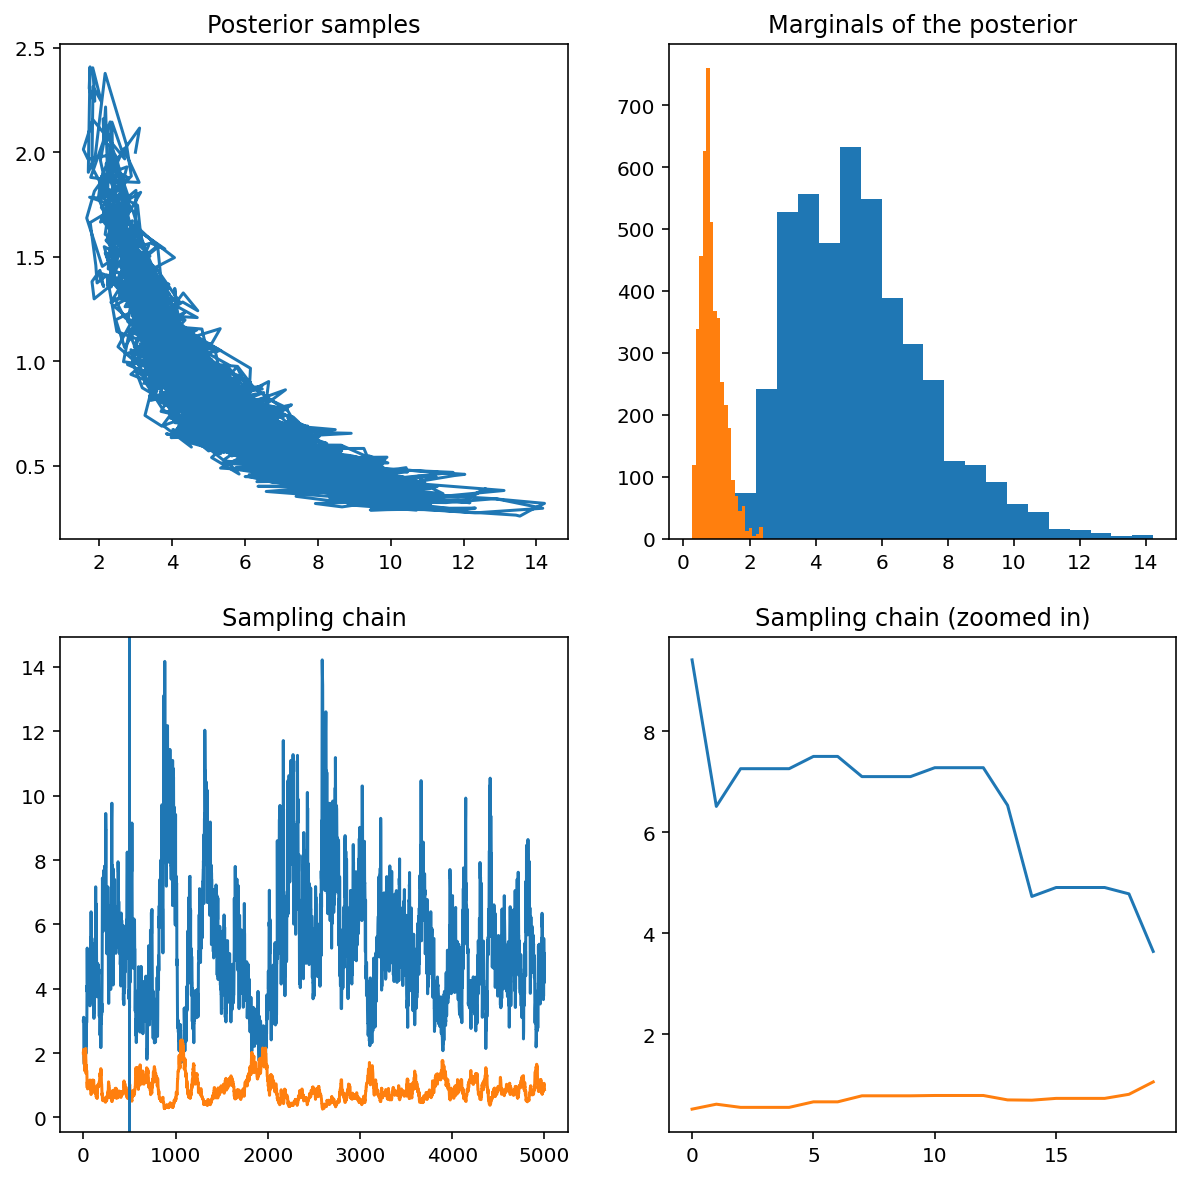

In [298]:
mh_samples = MetropolisHastings(x_samples, 3., 2., 5000)
plotSamples(mh_samples)

In [299]:
print("Expectation of the estimate u:", np.mean(mh_samples[500:,0]))
print("Variance of the estimate u:", np.var(mh_samples[500:,0]))
print()
print("Expectation of the estimate v:", np.mean(mh_samples[500:,1]))
print("Variance of the estimate v:", np.var(mh_samples[500:,1]))

Expectation of the estimate u: 5.350978520761398
Variance of the estimate u: 4.098920896384457

Expectation of the estimate v: 0.8704472646048499
Variance of the estimate v: 0.12750056752991087


## Gibbs sampler

Implement Gibbs sampler for the previous model.

In [300]:
def Gibbs(x, u, v, T):
    # Storage for samples
    samples = [u, v]
    for t in range(T):
        # Sample u conditional on v
        u = np.random.gamma(5 + x.sum(), scale=1/(1 + len(x) * v))

        # Sample v conditional on u
        v = np.random.gamma(4 + x.sum(), scale=1/(4 + len(x) * u))

        samples = np.vstack([samples, [u, v]])
    return samples

Expectation of the estimate u: 4.833081297985121
Variance of the estimate u: 2.9082461241397093

Expectation of the estimate v: 0.9739755179610995
Variance of the estimate v: 0.12281218026920467


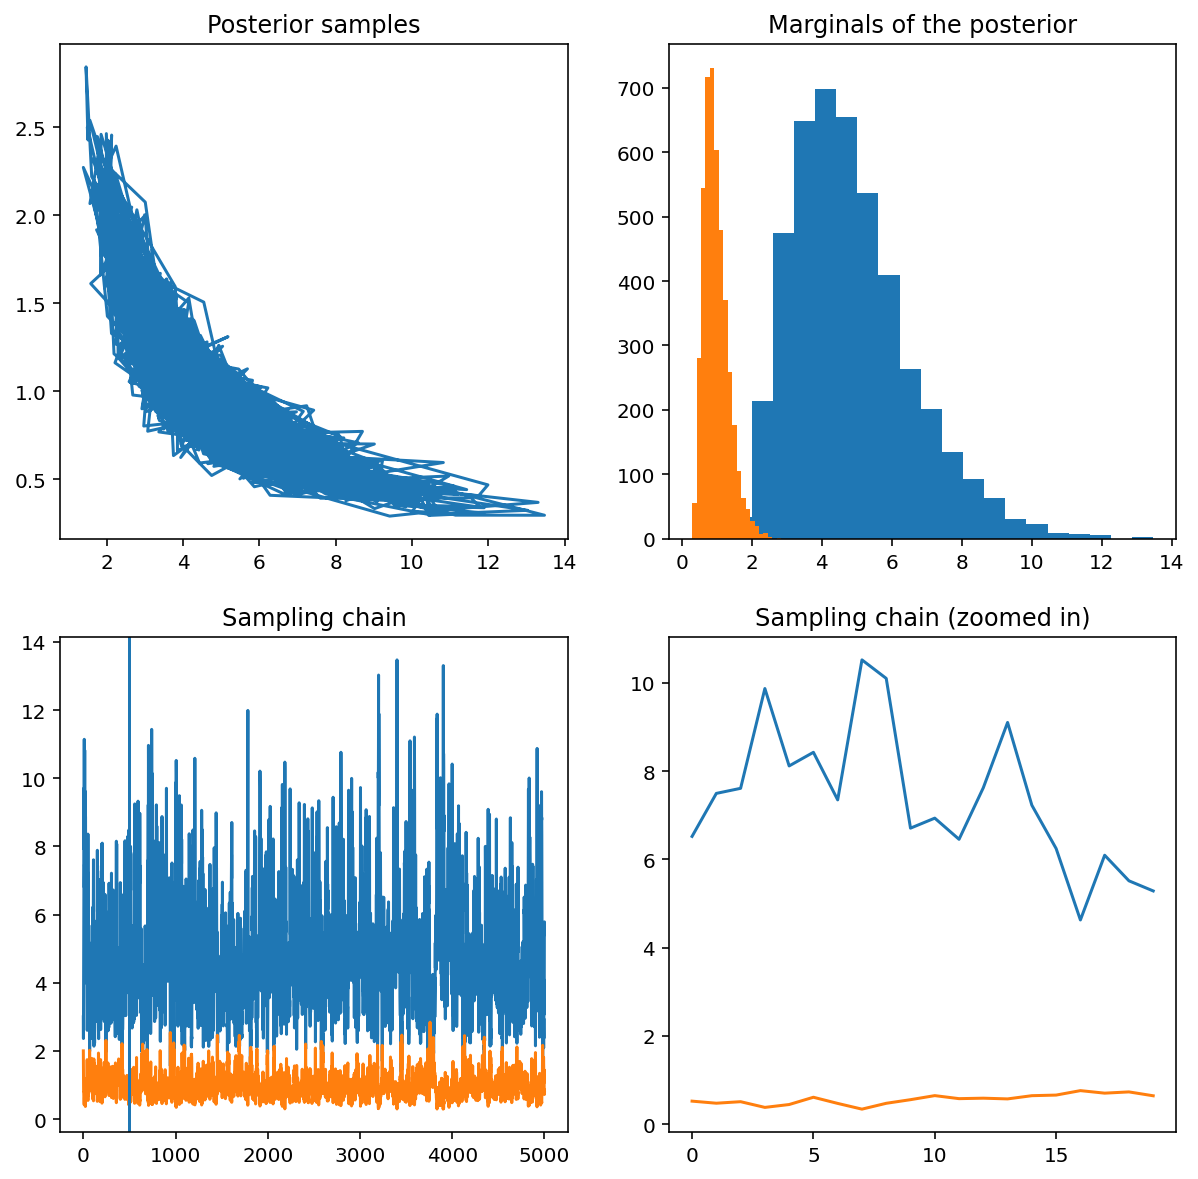

In [301]:
gibbs_samples = Gibbs(x_samples, 3.0, 2., 5000)

print(f'Expectation of the estimate u: {np.mean(gibbs_samples[500:,0])}')
print(f'Variance of the estimate u: {np.var(gibbs_samples[500:,0])}')
print()
print(f'Expectation of the estimate v: {np.mean(gibbs_samples[500:,1])}')
print(f'Variance of the estimate v: {np.var(gibbs_samples[500:,1])}')


plotSamples(gibbs_samples, type='-')
#plotSamples(gibbs_samples, type='.')  # This looks better as plot

**(e)** From the experiments carried out we see that the Gibbs sampler present less variance in the parameter estimantion as shown in the sampling chain. Furhtermore from the histogram we see that the marginal of the posteriori are more centered than Metropolis Hasting algorithm. 

Last, but not least, Gibbs sampler performs way faster than its counterpart.
Altough both achieve approximately the same results, but with different estimate variance of the parameters.

# Latent Dirichlet allocation

In [3]:
from scipy.stats import dirichlet
from numpy.random import choice as nprc
import time

data = np.loadtxt('./exercise2data.csv', delimiter=',').astype(int)
print('Data shape ',data.shape) #40 Docs each of 50 length and 100 words
N = data.shape[0]
L = data.shape[1]
K = 10
V = 100
vocabulary = np.arange(0, 100)
print('Vocabulary ',vocabulary)

alpha = np.repeat(0.1, K)
gamma = np.repeat(0.1, V)

Pi = dirichlet.rvs(alpha, size=N)
 
Q = np.zeros((N, L), dtype=int)
for i in range(0, N):
    Q[i, :] = nprc(K, p=Pi[i], size=L)

Data shape  (40, 50)
Vocabulary  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


## Direct Gibbs Sampler

In [4]:
'''
Count number occurances alon axis

@Param X: matrix 

'''
def count_topics(X, K):
    count = np.zeros((X.shape[0], K))
    for i in range(0, X.shape[0]):
        for k in range(0, K):
            count[i, k] = np.sum(X[i, :] == k)
        
    return count

def vocabularycount(vocabulary, data, Q, classes):
    V_K = np.zeros(shape=(len(vocabulary), len(classes)))
    k_locs = []
    for k in classes:
        k_locs.append(np.argwhere(Q.flatten() == k))
        
    for v in vocabulary:
        v_idx = np.argwhere(data.flatten() == v)
        
        for k in classes:
            V_K[v, k] = len(np.intersect1d(v_idx, k_locs[k]))
    
    return V_K

def count_matrix(Y, Q, V, K):
    N = Y.shape[0]
    L = Y.shape[1]
    
    C = np.zeros((N, V, K))
    for i in range(0, N):
        
        #first compute all argwhere
        idx_v = []
        for v in range(0, V):
            idx_v.append(np.argwhere(Y[i, ] == v))
        idx_k = []
        for k in range(0, K):
            idx_k.append(np.argwhere(Q[i, ] == k))
        
        #intersect
        for v in range(0, V):
            for k in range(0, K):
                C[i, v, k] = len(np.intersect1d(idx_v[v], idx_k[k]))
    return C

def heatmap_count(nheatmaps, Y, Q, V, K):
    res = count_matrix(Y, Q, V, K)
    fig, axes = plt.subplots(nrows=1, ncols=nheatmaps, figsize=(10,4))
    for j in range(0, nheatmaps):
            i = np.random.randint(0, N)
            #filter with labels present in the data
            c_i = res[i][data[i]]
            img = axes[j].imshow(c_i)
            fig.colorbar(img, ax=axes[j])
    plt.show()
    
def hist_q_maps(Q, N , doc_samples = 16):  
    rows = np.sqrt(doc_samples).astype(int)
    fig, axes = plt.subplots(nrows=rows, ncols=rows, figsize=(8, 8))
    idx = np.random.randint(0, N, size=doc_samples)
    i=0
    for r in range(0, rows):
        for c in range(0, rows):
            axes[r, c].hist(Q[i])
            i+=1
    fig.suptitle('Q Hist. for random sampled docs', fontsize=8)
    plt.show()

In [5]:
from scipy.special import logsumexp

def LDAGibbs(Y, Q, alpha, gamma, K, T):
    # Storage for samples
    samples = [Q]
    for t in range(0, T):
        count_qk = count_topics(Q, K)
        new_alpha = alpha + count_qk

        pi_i = []
        for i in range(0, N):
            new_alpha = alpha + count_qk[i, :]
            pi_i.append(dirichlet(alpha=new_alpha).rvs())
        Pi = np.array(pi_i).reshape((N, K))


        V_K  = vocabularycount(vocabulary, Y, Q, np.arange(0, K))
        b_k = []
        for k in range(0, K):
            new_gamma = gamma + V_K[:, k]
            b_k.append(dirichlet(alpha=new_gamma).rvs())

        B = np.array(b_k).reshape((K, V))

        for i in range(0, N):
            for l in range(0, L):
                prob = np.zeros(K)
                for k in range (0, K):
                    prob[k] = np.exp(np.log(Pi[i, k]) + np.log(B[k, Y[i, l]]))
                    
                prob = (prob / prob.sum()) #normalization

                Q[i, l] = nprc(K, p=prob)

        samples = np.vstack([samples, [Q]])
    return samples

In [337]:
tic1 = time.perf_counter()
T=500
samples = LDAGibbs(data, Q, alpha, gamma, K, T)
toc1 = time.perf_counter()
print('Tic-Toc seconds: ', abs(tic1 - toc1)) #roughly 2 minutes

Tic-Toc seconds:  111.00829061200056


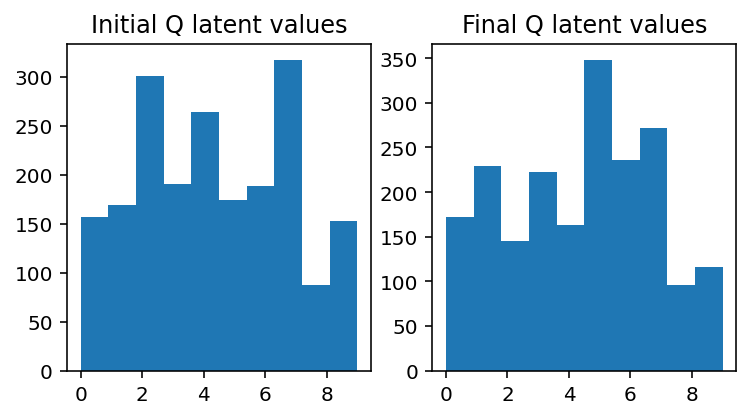

In [338]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axes[0].hist(samples[0].flatten())
axes[0].set_title('Initial Q latent values')
axes[1].hist(samples[-1].flatten())
axes[1].set_title('Final Q latent values')
plt.show()

In [339]:
warmup=250
q_k_count = []
for sample in samples[warmup:]:
    q_k_count.append(np.bincount(sample.flatten()))
    
q_k_count = np.array(q_k_count)
q_k_count.shape
print('Estimated classes numbers in docs')
print(q_k_count.mean(axis=0))

Estimated classes numbers in docs
[191.07171315 230.53784861 154.17131474 198.55776892 163.86454183
 358.29083665 206.73306773 280.22709163 118.01195219  98.53386454]


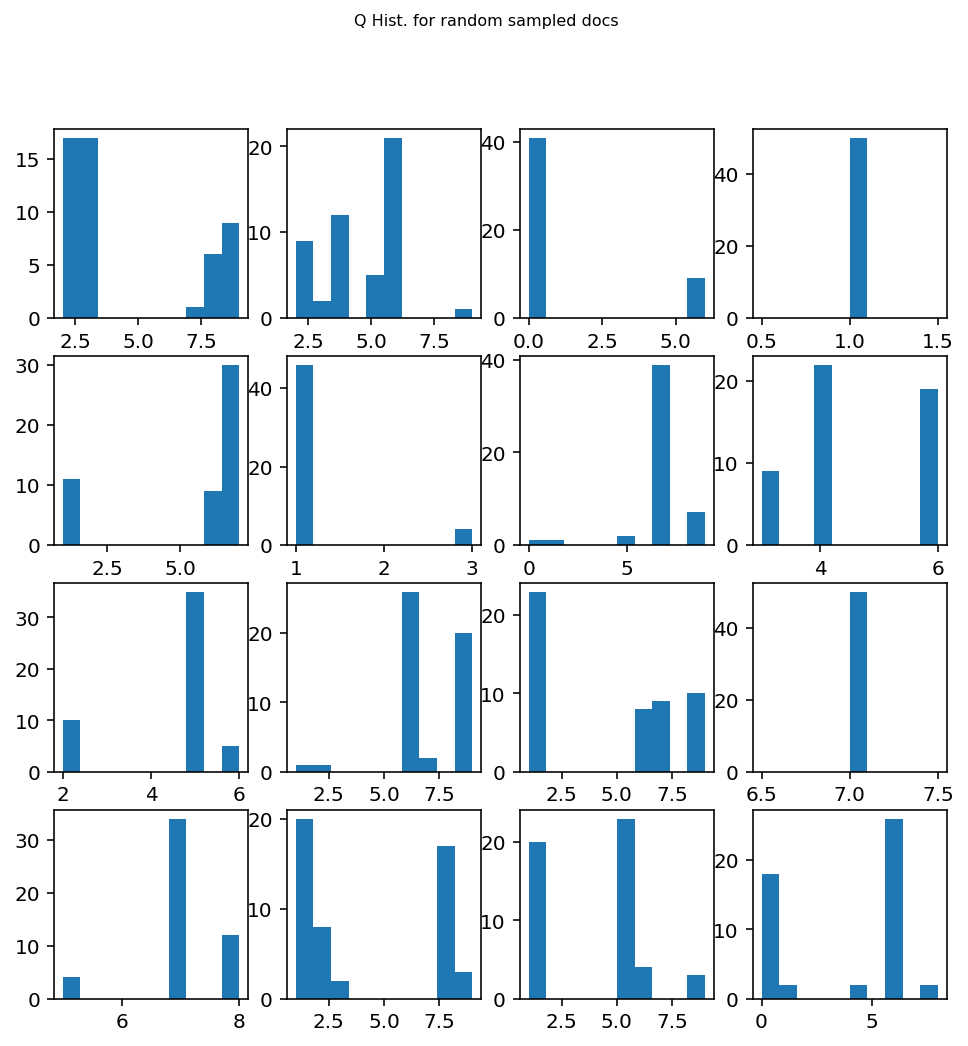

In [365]:
hist_q_maps(samples[-1], N)


**(a) Goodness of results**

The result achieved is as expected, indeed by looking at the first histogram of the **"final Q latent matrix"** we see that some classes are more relevant and present than others in **all** the documents.

Instead, by looking at **single** documents we see sparsity and prevelance for a few classes.

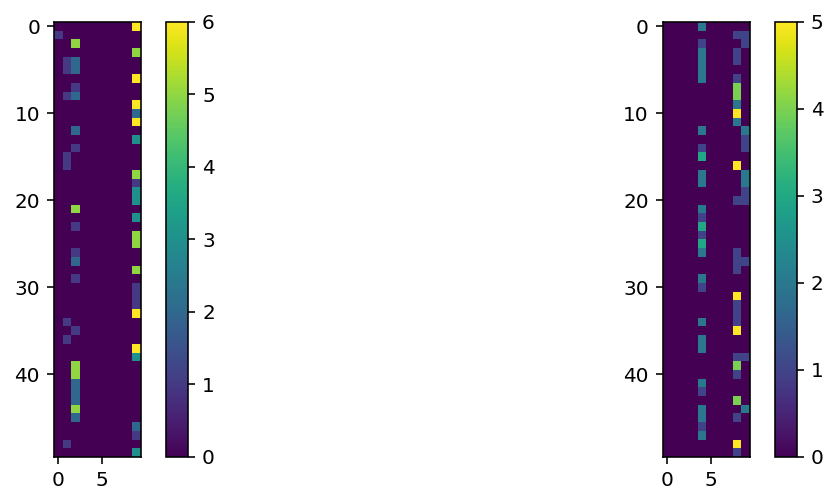

In [310]:
heatmap_count(2, data, samples[-1], V, K)

In the heatmap above we can also see how many times each word included in the document is mapped into some classes  from a random sampled document.
Each vocabulary it's mostly mapped in some few specific classes. Highlighting the fact that the same word is associated to the same or few classes.<br/>
The resulting in heatmap is sparse, each document present some major classes (classes with most mapped values). These latent variables can describe then the topic of the entire document.

## Collapsed Gibbs

In [6]:
def CollapsedGibbs(Y, Q, alpha, gamma, C, K, V, T):
    # Storage for samples
    samples = [Q]
    
    #Marginal counts
    C_ik = np.sum(C, axis = 1)
    C_vk = np.sum(C, axis = 0)
    C_k = np.sum(C_vk, axis=0)
    n_iv = np.sum(C, axis=2)
    Li = np.sum(C_ik, axis=1)
    
    for t in range(0, T):
        
        for i in range(0, N):
            for l in range(0, L):
                
                prob_Q_il = np.zeros(K, dtype='float')
                
                # Decrement relevant counts
                C_ik[i, Q[i, l]] -= 1
                C_vk[Y[i, l], Q[i, l]] -= 1
                C_k[Q[i, l]] -= 1
                n_iv[i, Y[i, l]] -= 1
                Li[i] -= 1 
                #C[i, v, Q[i, l]] = -1
                
                #Compute p(Q_il = k)
                for k in range(0, K):
                    prob_Q_il[k] = (C_vk[Y[i, l], k] + gamma[k]) / (C_k[k] + V * gamma[k]) \
                                * ((C_ik[i, k] + alpha[k]) / (Li[i] + K * alpha[k]))
                    
                prob_Q_il = prob_Q_il / np.sum(prob_Q_il) #Normalize
                    
                #Update Matrix
                Q[i, l] = nprc(K, p=prob_Q_il)
                
                #Update count matrix
                C_ik[i, Q[i, l]] += 1
                C_vk[Y[i, l], Q[i, l]] += 1
                C_k[Q[i, l]] += 1
                n_iv[i, Y[i, l]] += 1
                Li[i] += 1 

                
        samples = np.vstack([samples, [Q]])
    return samples

In [366]:
alpha = np.repeat(0.1, K)
gamma = np.repeat(0.1, V)

Pi = dirichlet.rvs(alpha, size=N)
 
Q = np.zeros((N, L), dtype=int)
for i in range(0, N):
    Q[i, :] = nprc(K, p=Pi[i], size=L)
    
tic1 = time.perf_counter()
T=500
C = count_matrix(data, Q, V, K)
samples = CollapsedGibbs(data, Q, alpha, gamma, C, K, V, T)
toc1 = time.perf_counter()
print('Tic-Toc seconds: ', abs(tic1 - toc1))

Tic-Toc seconds:  93.72740109000006


Estimated classes numbers in docs
[285.78884462 162.03187251 223.15537849 357.95219124 119.87649402
 197.08366534 189.93625498 104.6812749  194.33067729 165.16334661]


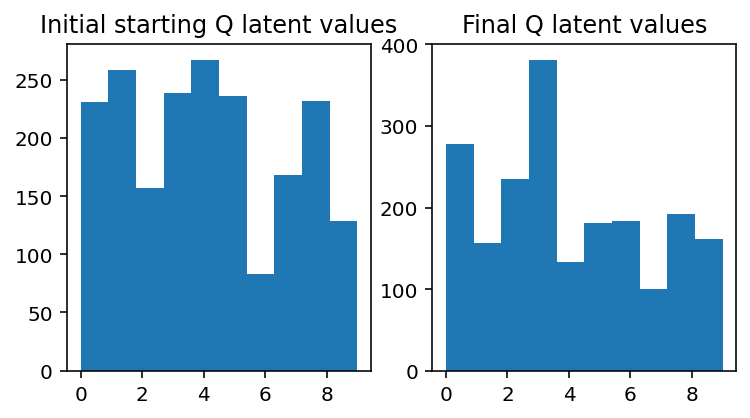

In [367]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axes[0].hist(samples[0].flatten())
axes[0].set_title('Initial starting Q latent values')
axes[1].hist(samples[-1].flatten())
axes[1].set_title('Final Q latent values')
plt.show()

warmup=250
q_k_count = []
for sample in samples[warmup:]:
    q_k_count.append(np.bincount(sample.flatten()))
    
q_k_count = np.array(q_k_count)
q_k_count.shape

print('Estimated classes numbers in docs')
print(q_k_count.mean(axis=0))

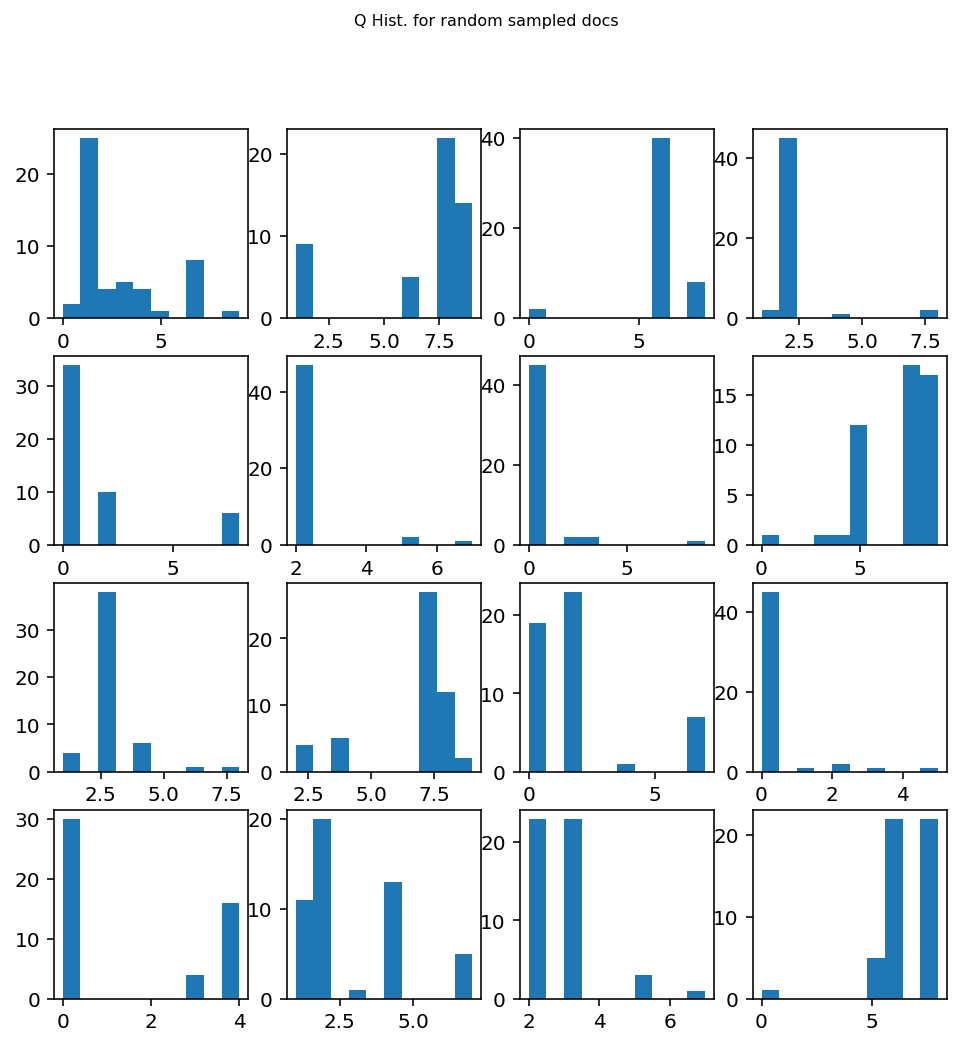

In [370]:
hist_q_maps(samples[-1], N)

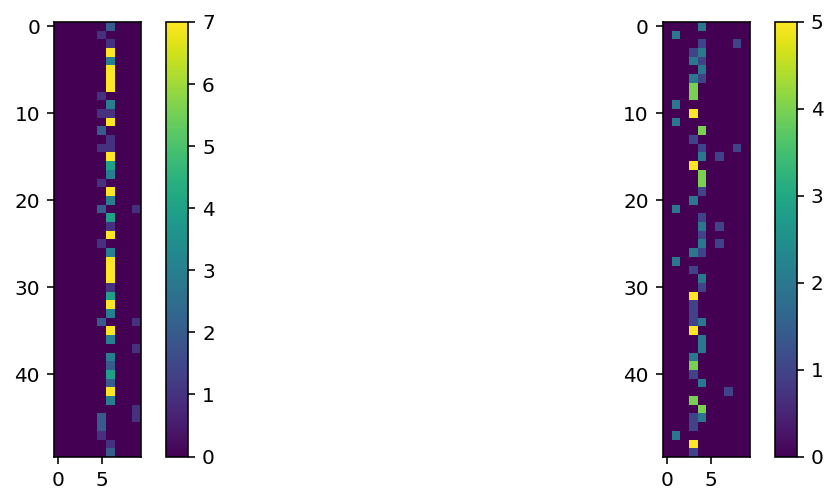

In [331]:
heatmap_count(2, data, samples[-1], V, K)

As we can see from the results the Collapsed Gibbs sampler is more **computationally efficient** (it takes less time for the same epochs) and it results into more sparse results than the Direct Gibbs Sampler.

## Hyperparameter tests

We now use the Collapsed Gibbs sampler, since it is more computationally efficient than the Direct Gibbs sampler, for testing how the results change according to $\alpha,\; \gamma$ and $K$

### Changing $\alpha, \; \gamma$

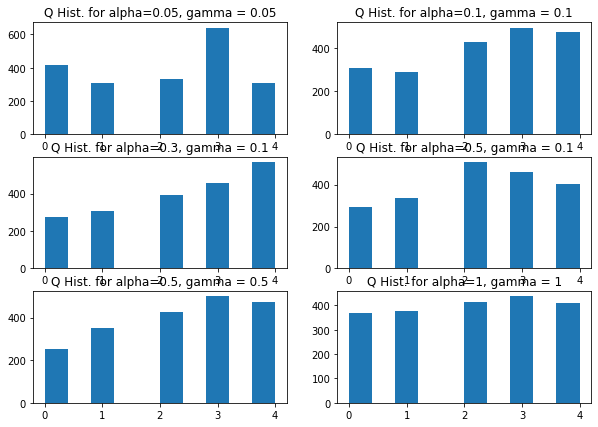

In [13]:
result = []
K = 5
alpha_gamma = [(0.05, 0.05), (0.1, 0.1), (0.3, 0.1), (0.5, 0.1), (0.5, 0.5), (1,1), ]
for idx, (a, g) in enumerate(alpha_gamma):
    alpha = np.repeat(a, K)
    gamma = np.repeat(g, V)

    Pi = dirichlet.rvs(alpha, size=N)

    Q = np.zeros((N, L), dtype=int)
    for i in range(0, N):
        Q[i, :] = nprc(K, p=Pi[i], size=L)

    T=500
    C = count_matrix(data, Q, V, K)
    result.append(CollapsedGibbs(data, Q, alpha, gamma, C, K, V, T)[-1])

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))
i = 0 
for r in range(0,3):
    for c in range(0,2):
        axes[r, c].hist(result[i].flatten())
        axes[r, c].set_title(f'Q Hist. for alpha={alpha_gamma[i][0]}, gamma = {alpha_gamma[i][1]}')
        i +=1
plt.show()

### Changing $K$

In [ ]:
result = []
K = [5, 10, 15, 20]
for idx, k in enumerate(K):
    alpha = np.repeat(0.1, k)
    gamma = np.repeat(0.1, V)

    Pi = dirichlet.rvs(alpha, size=N)

    Q = np.zeros((N, L), dtype=int)
    for i in range(0, N):
        Q[i, :] = nprc(k, p=Pi[i], size=L)

    T=500
    C = count_matrix(data, Q, V, k)
    result.append(CollapsedGibbs(data, Q, alpha, gamma, C, k, V, T)[-1])
    
    print(f'Class K={k} done.')

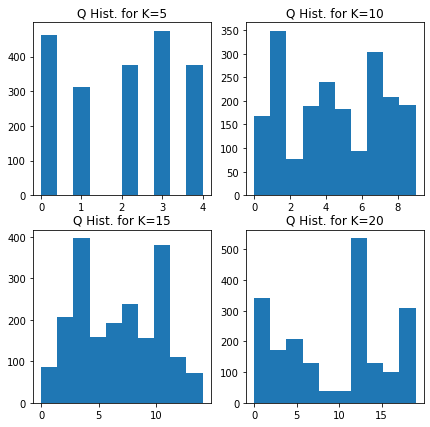

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
i = 0 
for r in range(0,2):
    for c in range(0,2):
        axes[r, c].hist(result[i].flatten())
        axes[r, c].set_title(f'Q Hist. for K={K[i]}')
        i +=1
plt.show()

By increasing the number of classes we see that the latent variables present less uniform distributed values of the associated topics across documents. <br/>
Thus resulting in a more sparse solution, which can be helpful to highlight most common topics in our documents. <br/> 
Further analysis should be carried out also by looking at singular document, the some pair correlation of their distribution across different documents could highligth interesting relationship among them.

A different behaviour can also be seen by changing the $\alpha$ and $\gamma$ parameters, as shown in the first histograms of the subsection. Indeed the chosen parameters describe the prior distribution of the latent variables, thus not choosing an appropriate parameter could also lead to worse convergence of the posterior, and favoring not the right solutions. We see that by choosing parameters below 1 we end up prefering sparse distributions, i.e. most of the values within a single sample will be close to 0, and the vast majority of the mass will be concentrated in a few of the values. On the other side using for example $\alpha=1, \gamma=1$ we define the prior to be a uniform distribution.

## Reporting results 

A better way of characterizing the topics would be to sample multiple times from the latent posterier distribution and look if the sampled variables are statistical significant or if they are extreme values from the posterior distribution.<br/>
Thus by defining a p-value threshold (e.g 0.05) from the sampled distributions we can define measures of certainty and a confidence intervals in our results.<br/> By defining the p-value acceptance ratio we are also able to calibrate the first type error that we commit in our results.<br/>
Among the sampled values after checking their statistical significant we could take the sample mean value. <br/>
Furthermore usage of statistics like the estimated variance for the sampled parameters could be helpful to highlight their convergence and understand the variance in the distribution.